Script fine-tunes a pretrained VGG16 model on the synthetic images dataset (shapes world), saves model, and visualises the embeddings

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

Preprocessing steps

In [23]:
# Preprocessing transformations for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match VGG input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG pre-trained mean and std
])

# Load the full dataset
full_dataset = datasets.ImageFolder('synthetic_shapes/', transform=transform)

# Split the dataset into training and testing (80-20 split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = full_dataset.classes
print(f"Classes: {class_names}")



Classes: ['circle', 'heart', 'hexagon', 'square', 'star', 'triangle']


Define model - VGG16

In [22]:
# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)

# Freeze all layers except the final classifier layer
for param in vgg_model.parameters():
    param.requires_grad = False

# Modify the final classifier layers to output embeddings (e.g., 128D embeddings)
vgg_model.classifier[6] = nn.Linear(4096, 128)  # Changing the final FC layer to 128 outputs

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Fine tune VGG model to the shapes dataset

In [ ]:
# Set the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=1e-4)

# Function to evaluate accuracy
def evaluate(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Training loop with evaluation at each epoch
num_epochs = 10
dataitems = 0
for epoch in range(num_epochs):
    vgg_model.train() 
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = vgg_model(inputs)

        # Compute loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()
        dataitems = dataitems + len(labels)
        print("Batch processed: " + str(dataitems))
        

    # Evaluate on training and testing sets after each epoch
    train_accuracy = evaluate(vgg_model, train_loader)
    test_accuracy = evaluate(vgg_model, test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


Batch processed: 32
Batch processed: 64
Batch processed: 96
Batch processed: 128
Batch processed: 160
Batch processed: 192
Batch processed: 224
Batch processed: 256
Batch processed: 288
Batch processed: 320
Batch processed: 352
Batch processed: 384
Batch processed: 416
Batch processed: 448
Batch processed: 480
Batch processed: 512
Batch processed: 544
Batch processed: 576
Batch processed: 608
Batch processed: 640
Batch processed: 672
Batch processed: 704
Batch processed: 736
Batch processed: 768
Batch processed: 800
Batch processed: 832
Batch processed: 864
Batch processed: 896
Batch processed: 928
Batch processed: 960
Batch processed: 992
Batch processed: 1024
Batch processed: 1056
Batch processed: 1088
Batch processed: 1120
Batch processed: 1152
Batch processed: 1184
Batch processed: 1216
Batch processed: 1248
Batch processed: 1280
Batch processed: 1312
Batch processed: 1344
Batch processed: 1376
Batch processed: 1408
Batch processed: 1440
Batch processed: 1472
Batch processed: 1504


Save fine-tuned model

In [ ]:
# Save the fine-tuned VGG model
model_path = "synthetic-shapes-model.pth"
torch.save(vgg_model.state_dict(), model_path)
print(f"Model saved to {model_path}")
vgg_model.load_state_dict(torch.load(model_path))
vgg_model.to(device) 
print("Model loaded successfully!")

Model saved to synthetic-shapes-model.pth
Model loaded successfully!


Generate embeddings for train set and test set

In [30]:
# Function to generate embeddings
def get_embeddings(dataloader):
    vgg_model.eval()
    embeddings = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get the embeddings (output of the final FC layer)
            embedding = vgg_model(inputs)
            embeddings.append(embedding.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    # Stack all the embeddings and labels
    embeddings = np.vstack(embeddings)
    labels_list = np.concatenate(labels_list)
    
    return embeddings, labels_list

# Get embeddings for train and test set
train_embeddings, train_labels = get_embeddings(train_loader)
test_embeddings, test_labels = get_embeddings(test_loader)


Visualise embeddings using tSNE mapping 

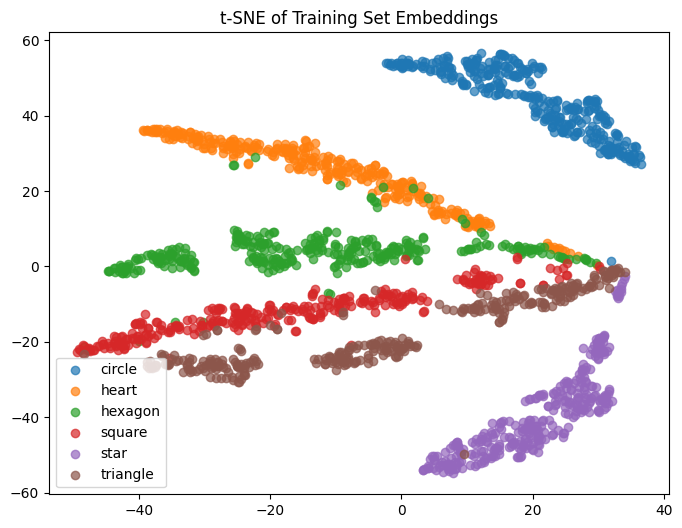

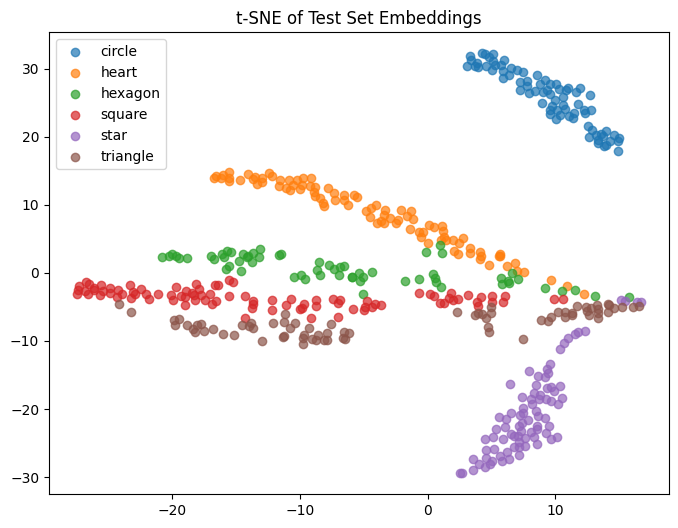

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Visualise embeddings for training set
reduced_train_embeddings = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    plt.scatter(reduced_train_embeddings[train_labels == i, 0], reduced_train_embeddings[train_labels == i, 1], label=class_name, alpha=0.7)
plt.legend()
plt.title('t-SNE of Training Set Embeddings')
plt.show()

# Visualize embeddings for test set
reduced_test_embeddings = tsne.fit_transform(test_embeddings)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    plt.scatter(reduced_test_embeddings[test_labels == i, 0], reduced_test_embeddings[test_labels == i, 1], label=class_name, alpha=0.7)
plt.legend()
plt.title('t-SNE of Test Set Embeddings')
plt.show()
